In [63]:
from simnibs import sim_struct, run_simnibs
import nilearn.image as img
import nilearn.plotting as niplot
import os
import numpy as np
from numpy import degrees, arcsin, arctan2, deg2rad, cos, sin

# SimNIBS Hot Tips

Data for this notebook can be found in:

```
/projects/jjeyachandra/simnibs_tutorial/data
```

Feel free to symlink or copy for your own personal use (it's my brain...)

## A Basic Run of SimNIBS

Ripped from their tutorial

In [2]:
# Initialize session
s = sim_struct.SESSION()
s.fnamehead = "../data/sub-CMHP001.msh"
s.pathfem = "../output"

In [3]:
from simnibs import SIMNIBSDIR

In [4]:
os.listdir(os.path.join(SIMNIBSDIR,'ccd-files'))

['Magstim_70mm_Fig8.ccd',
 'Magstim_70mm_Fig8.nii.gz',
 'MagVenture_MC_B70.nii.gz',
 'MagVenture_MC_B70.ccd']

In [5]:
# Set TMS position list
tmslist = s.add_tmslist()
tmslist.fnamecoil = "Magstim_70mm_Fig8.nii.gz"

In [6]:
# Add a position to the position list
pos = tmslist.add_position()
pos.centre = 'C1'
pos.pos_ydir = 'CP1'

In [29]:
# Options for mapping
s.map_to_fsavg = True
s.map_to_MNI = True

## Will only work with CAT12
s.map_to_surf = False

In [30]:
run_simnibs(s)

[ simnibs ]INFO: Head Mesh: /projects/jjeyachandra/simnibs_tutorial/data/sub-CMHP001.msh
[ simnibs ]INFO: Subject Path: /projects/jjeyachandra/simnibs_tutorial/data/m2m_sub-CMHP001
[ simnibs ]INFO: Simulation Folder: /projects/jjeyachandra/simnibs_tutorial/output
[ simnibs ]INFO: Running simulations in the directory: /projects/jjeyachandra/simnibs_tutorial/output
[ simnibs ]INFO: Running Poslist Number: 1
[ simnibs ]INFO: Began to run TMS simulations
[ simnibs ]INFO: Coil file: /usr/local/lib/python3.7/dist-packages/simnibs/ccd-files/Magstim_70mm_Fig8.nii.gz
[ simnibs ]INFO: Using isotropic conductivities
[ simnibs ]INFO: Calculating Coil position from (centre, pos_y, distance)
[ simnibs ]INFO: Matsimnibs: 
[[ 8.8121e-01  6.9226e-02  4.6762e-01 -3.3527e+01]
 [ 5.9473e-02 -9.9759e-01  3.5608e-02 -3.0903e+01]
 [ 4.6896e-01 -3.5671e-03 -8.8321e-01  1.0692e+02]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  1.0000e+00]]
[ simnibs ]INFO: Assembling FEM Matrx
[ simnibs ]INFO: 42.45s to assemble FEM 

OSError: Could not find surface files in m2m folder. SPM-only segmentation?

##  MNI Coordinate Projection

MNI coordinates can be transformed into subject space pretty easily with a SimNIBS command-line tool called `mni2subject_coords`.

Here's an example for left DLPFC (-30, 43, 23)

In [13]:
!mni2subject_coords -m /projects/jjeyachandra/simnibs_tutorial/data/m2m_sub-CMHP001/ \
    -c "-30" "43" "23" \
    -t nonl

Transformed coodinates:
[-27.78 31.57 58.18]


Alternatively this can be done directly using the Python API

In [14]:
import simnibs.msh.transformations as transformations

In [15]:
m2m_dir = "../data/m2m_sub-CMHP001/"
coords = [-30, 43, 23]
xfm_res = transformations.warp_coordinates(
    coordinates=coords,m2m_folder=m2m_dir,
    transformation_direction='mni2subject')
print(xfm_res)

(['Generic'], array([[-27.77887344,  31.56871796,  58.17615509]]), [None], [None])


The coordinates that we used were brain coordinates, so these need to be projected onto the subject scalp. 

In addition, even _MNI TMS Coordinates_ need to be projected onto the scalp. Otherwise the imperfect MNI coordiante may result in a TMS coil embedded within the subject skull or floating above the subject's head.

This can also be achieved via the `transformations` API.

First we need to read in the mesh file which contains the scalp geometry:

In [16]:
from simnibs.msh import mesh_io

In [17]:
mesh = mesh_io.read_msh('../data/sub-CMHP001.msh')

In [18]:
subject_ldlpfc = xfm_res[1]
subject_dlpfc_scalp = transformations.project_on_scalp(
    coords = subject_ldlpfc,
    mesh=mesh,
    distance=1
)
print(subject_dlpfc_scalp)

[[-45.13417276  43.07987477  72.64537813]]


In [19]:
t1 = img.load_img('../data/m2m_sub-CMHP001/T1fs_nu_conform.nii.gz')

Original coordinates

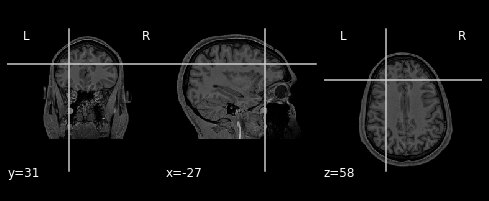

In [21]:
niplot.plot_anat(t1,
                cut_coords=subject_ldlpfc[0])

Projected onto the scalp

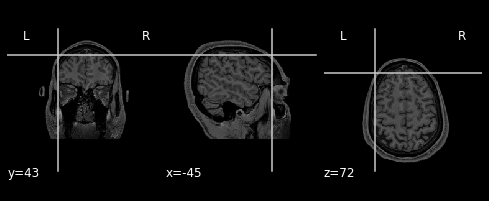

In [22]:
niplot.plot_anat(t1,
                cut_coords=subject_dlpfc_scalp[0])

## Defining an orientation

To define an orientation we use the BrainSight convention in which:

1. 0 degrees is defined as pointing anteriorly
2. 180 degrees is defined as pointing posteriorly
3. (+) rotations rotate counter-clockwise
4. (-) rotations rotate clockwise

If we wanted to:

1. Target left DLPFC
2. Have the coil pointing posteriorly 
3. Angle *away from the midline* at 45 degrees

We'd calculate our final desired "Brainsight angle" as:

1. Start with 180 degrees to point the handle posteriorly
2. Subtract (rotate clockwise) by 45 degrees
3. The BrainSight twist parameter is therefore 155 degrees

Next, all we need is the scalp normal which will allow us to position the coil such that the coil is flat against the scalp.

In [95]:
# To angle 45 degrees from midline in BrainSight
brainsight_twist = 155

**Step 1: Compute the normal of the scalp right under-neath the coil**

In [102]:
closest_node, node_index = mesh.nodes.find_closest_node([subject_dlpfc_scalp],
                                           return_index=True)
print(closest_node, node_index)

# Extract from list of list
node_index = node_index[0][0]

[[[-44.440907  42.625675  72.085838]]] [[403303]]


In [104]:
node_normal = mesh.nodes_normals(smooth=2).value[node_index]
print(node_normal)

[-0.69374112  0.45589802  0.55756636]


**Step 2: With this we can figure out the rest of the simulation matrix**

The function below takes the following:

1. a normal vector that we computed earlier
2. the "BrainSight twist" parameter in degrees
3. The coil centre position

And returns to you a matsimnibs matrix that can be directly used by simnibs

In [105]:
def get_matsimnibs(n,twist,centre):
    
    # Compute euler angles
    alpha = arctan2(-n[1],n[2])
    beta = arcsin(n[0])
    gamma = deg2rad(twist)
    
    # Define rotation matrices for XYZ variant of 
    # tait-bryan rotation matrices 
    R_ap = np.array([
        [1, 0, 0],
        [0, cos(alpha), -sin(alpha)],
        [0, sin(alpha), cos(alpha)]
    ])
    
    R_lr = np.array([
        [cos(beta), 0, sin(beta)],
        [0, 1, 0],
        [-sin(beta), 0, cos(beta)]
    ])
    
    R_tw = np.array([
        [cos(gamma), -sin(gamma), 0],
        [sin(gamma), cos(gamma), 0],
        [0, 0, 1]
    ])
    
    # Get full rotation matrix of coil onto scalp plane
    R = R_ap @ R_lr @ R_tw
    
    # Invert normal and X to maintain right-handedness
    R[:3,1] = -R[:3,1]
    R[:3,2] = -R[:3,2]
  
    # Construct matsimnibs
    msn = np.zeros((4,4))
    msn[:3,:3] = R
    msn[:3,3] = centre
    
    return msn

In [92]:
# Get 45 degree matsimnibs matrix over DLPFC
deg_45_msn = get_matsimnibs(node_normal,twist=155,c=subject_dlpfc_scalp)

In [ ]:
osl

In [119]:
# Now run a simulation with our matsimnibs matrix
s = sim_struct.SESSION()
s.fnamehead = "../data/sub-CMHP001.msh"
s.pathfem = "../output"
s.map_to_fsavg = True
s.map_to_MNI = True
tmslist = s.add_tmslist()
tmslist.fnamecoil = "Magstim_70mm_Fig8.nii.gz"
pos = tmslist.add_position()
pos.matsimnibs = deg_45_msn

In [120]:
run_simnibs(s, cpus=12)

[ simnibs ]INFO: Head Mesh: /projects/jjeyachandra/simnibs_tutorial/data/sub-CMHP001.msh
[INFO - simnibs._prepare() ] Head Mesh: /projects/jjeyachandra/simnibs_tutorial/data/sub-CMHP001.msh
[ simnibs ]INFO: Subject Path: /projects/jjeyachandra/simnibs_tutorial/data/m2m_sub-CMHP001
[INFO - simnibs._prepare() ] Subject Path: /projects/jjeyachandra/simnibs_tutorial/data/m2m_sub-CMHP001
[ simnibs ]INFO: Simulation Folder: /projects/jjeyachandra/simnibs_tutorial/output
[INFO - simnibs._prepare() ] Simulation Folder: /projects/jjeyachandra/simnibs_tutorial/output
[ simnibs ]INFO: Running simulations in the directory: /projects/jjeyachandra/simnibs_tutorial/output
[INFO - simnibs.  run() ] Running simulations in the directory: /projects/jjeyachandra/simnibs_tutorial/output
[ simnibs ]INFO: Running Poslist Number: 1
[INFO - simnibs.  run() ] Running Poslist Number: 1
[ simnibs ]INFO: Began to run TMS simulations
[INFO - simnibs.run_simulation() ] Began to run TMS simulations
[ simnibs ]INFO: C

['/projects/jjeyachandra/simnibs_tutorial/output/sub-CMHP001_TMS_1-0001_Magstim_70mm_Fig8_nii_scalar.msh']

In [ ]:
# Compare to fieldopt?
